<h1>ZMGSN Lista 4. - Sieci syjamskie</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem sieci dwójkowej</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki sieci dwójkowej</li>(10pkt)
<li>Dokonać modyfikacji sieci dwójkowej w celu zbadania wpływu architektury na wyniki</li>(10pkt)
<li>Na podstawie implementacji sieci dwójkowej zaimplementować sieć trójkową. Należy zaimplementować klasę obsługującą zbiór danych, strukturę samej sieci oraz zmodyfikowaną wersję funkcji straty.</li> (30pkt)
<li>Dokonać ewaluacji opracowanej sieci trójkowej zgodnie z punktami 2. i 3.</li>(20pkt)
<li>Porównać jakość działania sieci dwójkowej z jakością działania sieci trójkowej</li>(15pkt)
<li>Opracować procedurę ewaluacji jakości działania sieci dwójkowej i sieci trójkowej, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE)</li>(15pkt)
</ol>

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [1]:
import random
import PIL.ImageOps

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset
import pickle

<h2>Konfiguracja wyświetlania wizualizacji w bibiliotece Matploltib</h2>

In [2]:
%matplotlib inline

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [3]:
torch.manual_seed(0)

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [4]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


<h2>Pobranie i rozpakowanie zbioru danych</h2>

In [9]:
import urllib.request
url = 'https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip'
filename = 'data'
urllib.request.urlretrieve(url, filename)

('data', <http.client.HTTPMessage at 0x237c4b98550>)

In [10]:
import zipfile
with zipfile.ZipFile('data_zip', 'r') as zip_ref:
    zip_ref.extractall('data')

<h2>Funkcje pomocnicze służące do wyświetlania próbek ze zbioru oraz generowania wykresów</h2>

In [24]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

<h2>Deklaracja klasy obsługującej pobrany zbiór danych</h2>

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # Potrzebujemy mniej więcej połowę par podobnych obrazków
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                # Wyszukiwanie zdjęcia tej samej osoby
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                # Wyszukiwanie zdjęcia innej  osoby
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

<h2>Wczytanie i wstępne przetwarzanie zbioru danych</h2>

In [6]:
# Wczytanie zbioru danych
folder_dataset = datasets.ImageFolder(root="data/data/faces/training")

# Zmiana rozmiaru próbek i konwersja na tensor
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Inicjalizacja klasy obsługującej zbiór danych
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

<h2>Przykładowy podgląd próbek ze zbioru danych</h2>

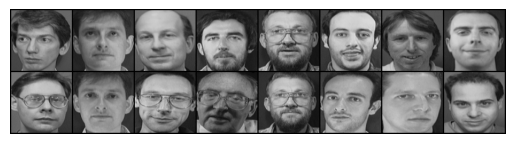

[1. 0. 1. 1. 0. 0. 1. 1.]


In [9]:
# Inicjalizacja klasy obsługującej zbiór danych
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=8, pin_memory=True)

# Ekstrakcja pierwszego pakietu danych
example_batch = next(iter(vis_dataloader))

# Pojedynczy pakiet danych zawiera tablicę zdjęć o rozmiarze 2 x 8 oraz etykietę
# Jeżeli etykieta jest równa 1 oznacza to, że para zdjęć nie przedstawia tej samej osoby.
# Jeżeli etykieta jest równa 0 oznacza to, że para zdjęć przedstawia tę samą osobę
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

<h2>Deklaracja podstawowej klasy modelu sieci dwójkowej<h2>

In [7]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # Funkcja zostanie wywołana osobno dla każdej próbki
        # Jej wyjście zostanie wykorzystane w celu określenia odległości
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # Funkcja przyjmuje obie próbki i zwraca parę wektorów
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

<h2>Definicja klasy reprezentującej kontrastową funkcję straty</h2>

In [8]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

<h2></h2>

<h2>Wczytanie zbioru uczącego</h2>

In [9]:
train_dataloader = vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=64, pin_memory=True)

<h2>Przykładowa pętla ucząca</h2>

Epoch number 0
 Current loss 1.9355040788650513

Epoch number 1
 Current loss 1.25612473487854

Epoch number 2
 Current loss 0.5884599089622498

Epoch number 3
 Current loss 1.0870063304901123

Epoch number 4
 Current loss 0.8286117315292358

Epoch number 5
 Current loss 0.6209768056869507

Epoch number 6
 Current loss 0.8563123345375061

Epoch number 7
 Current loss 0.664265513420105

Epoch number 8
 Current loss 0.6480986475944519

Epoch number 9
 Current loss 1.104109764099121

Epoch number 10
 Current loss 0.6663983464241028

Epoch number 11
 Current loss 0.6704508066177368

Epoch number 12
 Current loss 0.7153469324111938

Epoch number 13
 Current loss 0.5130994319915771

Epoch number 14
 Current loss 0.6328416466712952

Epoch number 15
 Current loss 0.522601306438446

Epoch number 16
 Current loss 0.5927109718322754

Epoch number 17
 Current loss 0.6133166551589966

Epoch number 18
 Current loss 0.41812533140182495

Epoch number 19
 Current loss 0.40620774030685425

Epoch number 

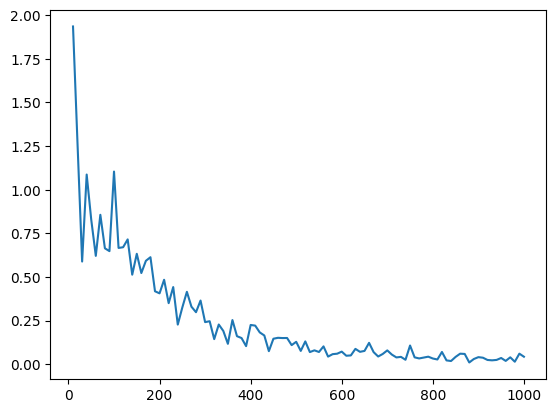

In [13]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

counter = []
loss_history = []
iteration_number= 0

# Iteracja po epokach
for epoch in range(100):

    # iteracja po pakietach
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Przeniesienie obrazów i etykiet do pamięci karty graficznej
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Ustawienie wartości gradientów na zero
        optimizer.zero_grad()

        # Przepuszczenie dwóch obrazów przez sieć i uzyskanie dwóch wektorów wyjściowych
        output1, output2 = net(img0, img1)

        # Obliczenie wartości funkcji straty na podstawie wektorów wyjściowych
        loss_contrastive = criterion(output1, output2, label)

        # Obliczenie zmian wag w oparciu o wartość funkcji straty
        loss_contrastive.backward()

        # Aktualizacja wag sieci
        optimizer.step()

        # Wyświetlenie wartości funkcji straty co 10 pakietów
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

<h2>Przykładowa funkcja służąca do ewaluacji sieci dwójkowej</h2>

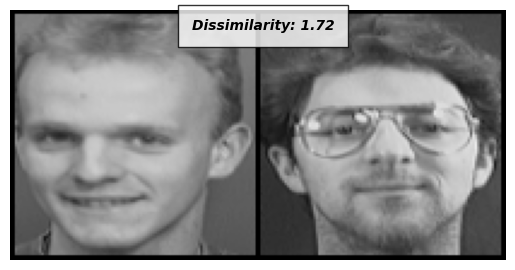

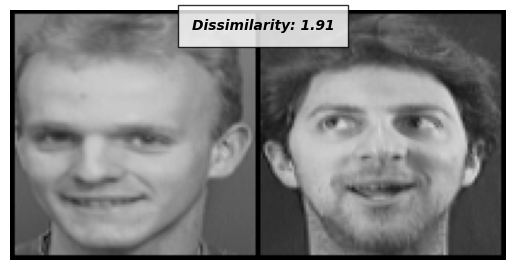

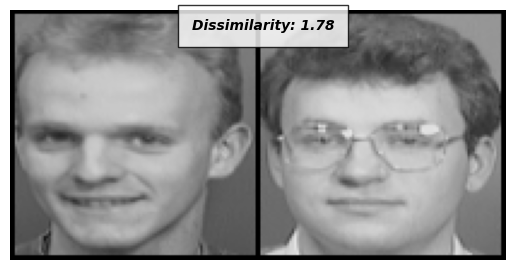

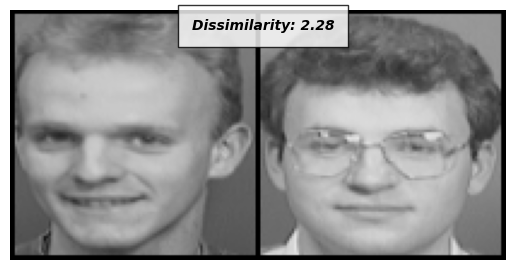

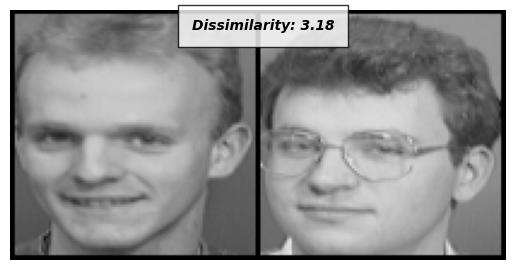

In [14]:
# Określenie ścieżki do katalogu ze zbiorem testowym i wczytanie go do obiektu klasy Dataloader
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Uzyskanie obrazu do przeprowadzenia ewaluacji
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iteracja po 5 obrazach i sprawdzenie ich podobieństwa z pierwszym obrazem (x0)
    _, x1, label2 = next(dataiter)

    # Konkatenacja dwóch przykładowych obrazów
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

Zadanie 2

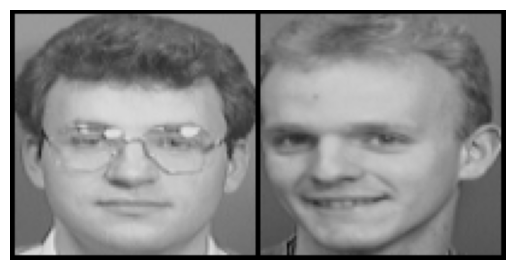

In [33]:
dataiter = iter(test_dataloader)

anchor1, _, _ = next(dataiter)
anchor2, _, _ = next(dataiter)

concatenated = torch.cat((anchor1, anchor2), 0)

imshow(torchvision.utils.make_grid(concatenated))

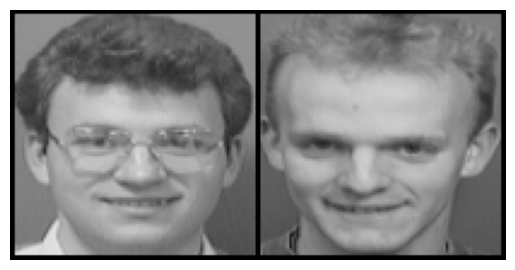

In [44]:
positive1, _, _ = next(dataiter)
positive2, _, _ = next(dataiter)

concatenated = torch.cat((positive1, positive2), 0)

imshow(torchvision.utils.make_grid(concatenated))

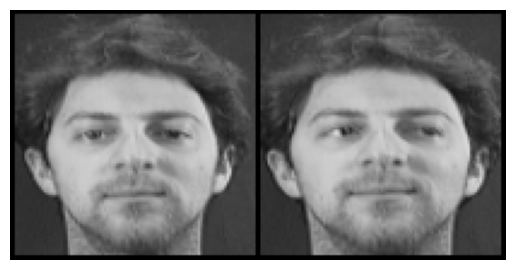

In [62]:
dataiter = iter(test_dataloader)

negative1, _, _ = next(dataiter)
negative2, _, _ = next(dataiter)

concatenated = torch.cat((negative1, negative2), 0)

imshow(torchvision.utils.make_grid(concatenated))

In [22]:
folder_dataset_test = datasets.ImageFolder(root="./data/data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=1, pin_memory=True)

In [26]:
def train_network(learning_rate, batch_size, num_epochs, test_dataloader):
    train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=batch_size, pin_memory=True)
    net = SiameseNetwork().to(device)
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    counter = []
    loss_history = []
    iteration_number = 0

    for epoch in range(num_epochs):
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            if i % 10 == 0:
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())


    net.eval() 

    concatenated1 = torch.cat((anchor1, positive1, negative1), 0)
    concatenated2 = torch.cat((anchor2, positive2, negative2), 0)

    output_anchor, output_positive = net(anchor1.to(device), positive1.to(device))
    positive_distance = F.pairwise_distance(output_anchor, output_positive)
    output_anchor, output_negative = net(anchor1.to(device), negative1.to(device))
    negative_distance = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated1), f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')

    output_anchor, output_positive = net(anchor2.to(device), positive2.to(device))
    positive_distance = F.pairwise_distance(output_anchor, output_positive)
    output_anchor, output_negative = net(anchor2.to(device), negative2.to(device))
    negative_distance = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated2), f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')

    return counter, loss_history

In [53]:
def show_plot(iteration, loss, title):
    plt.plot(iteration, loss)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

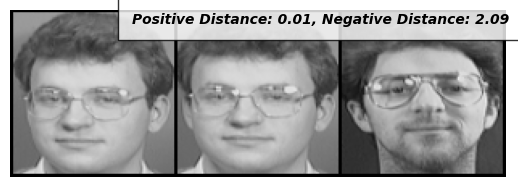

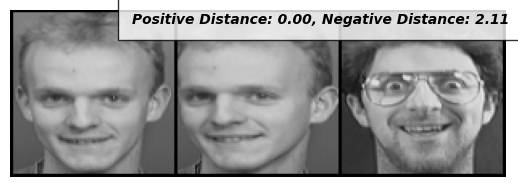

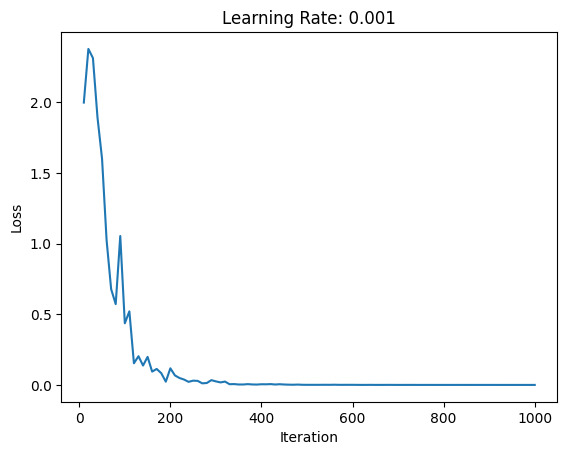

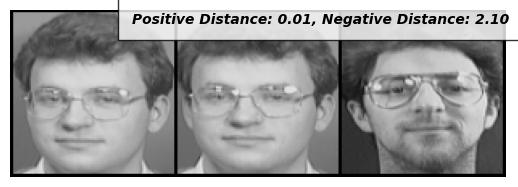

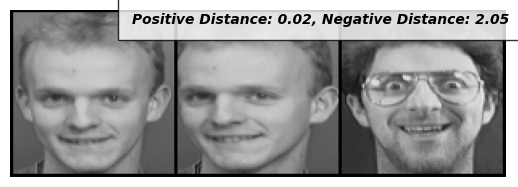

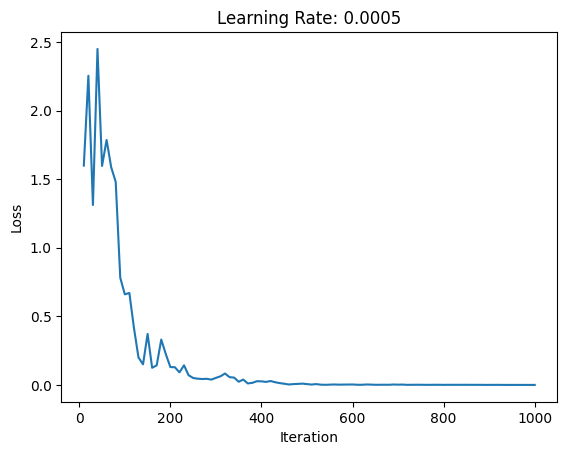

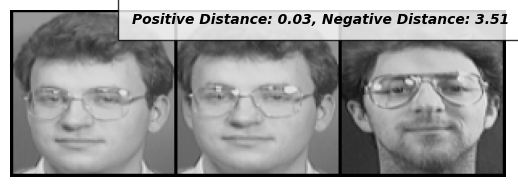

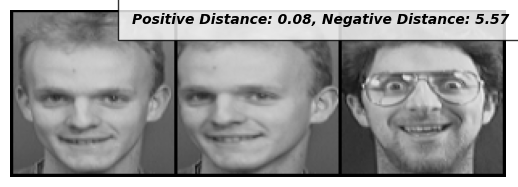

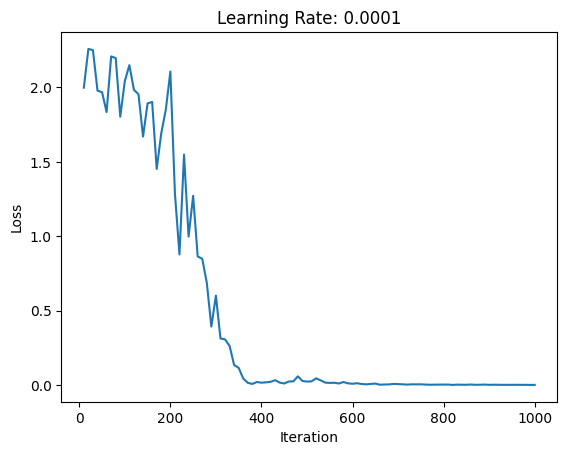

In [30]:
learning_rates = [0.001, 0.0005, 0.0001]

for lr in learning_rates:
    counter, loss_history = train_network(lr, 64, 100, test_dataloader)
    show_plot(counter, loss_history, title=f"Learning Rate: {lr}")

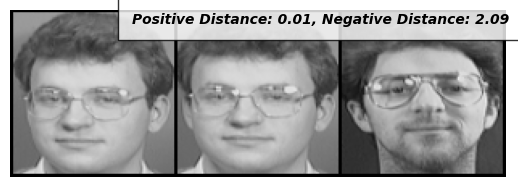

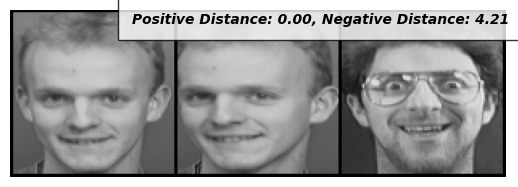

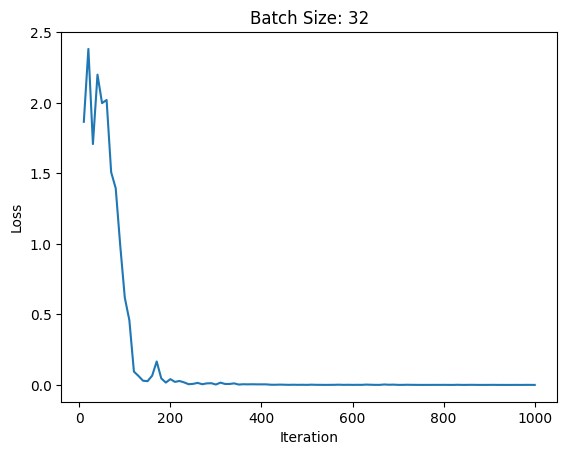

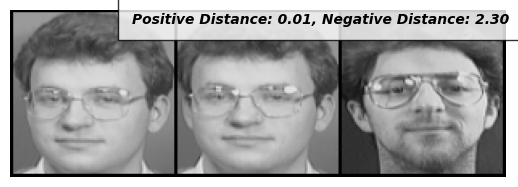

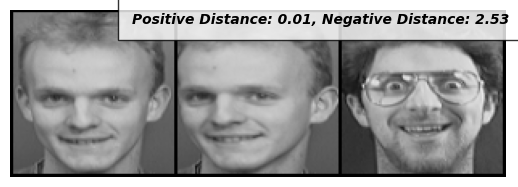

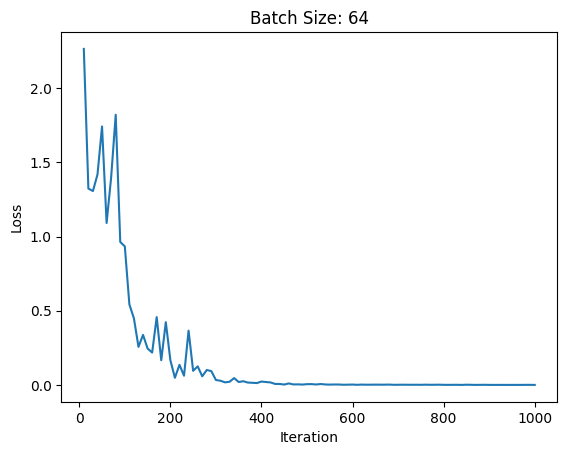

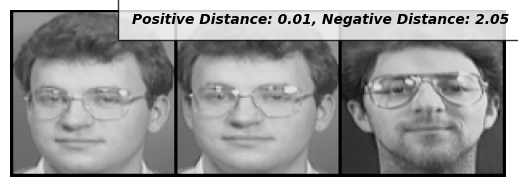

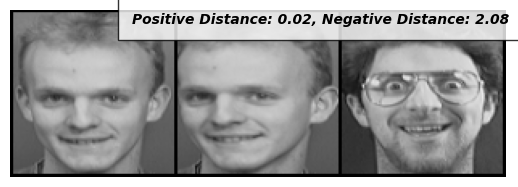

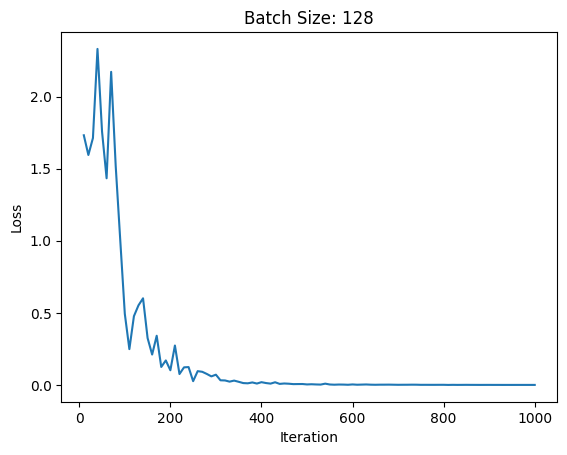

In [31]:
batch_sizes = [32, 64, 128]

for batch_size in batch_sizes:
    counter, loss_history = train_network(0.0005, batch_size, 100, test_dataloader)
    show_plot(counter, loss_history, title=f"Batch Size: {batch_size}")

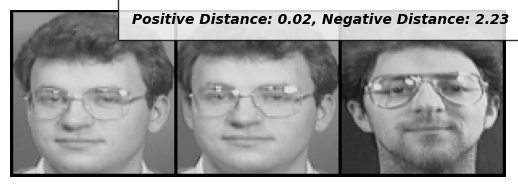

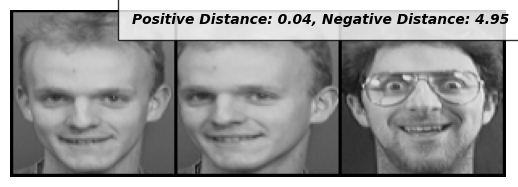

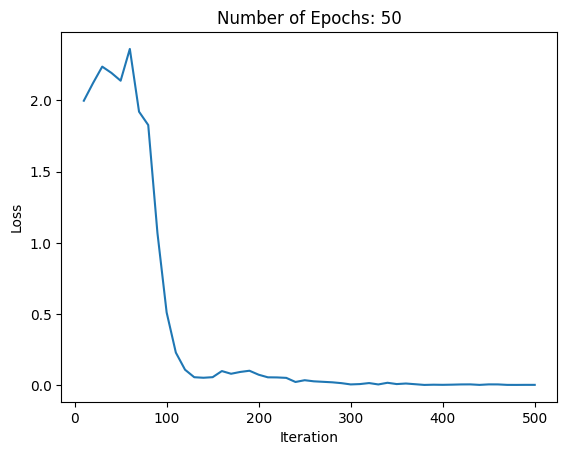

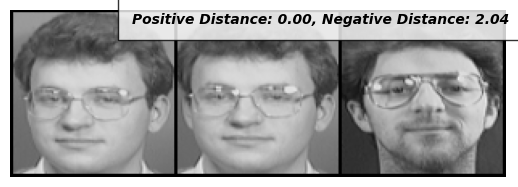

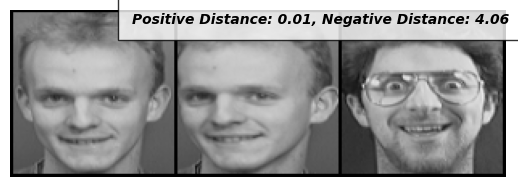

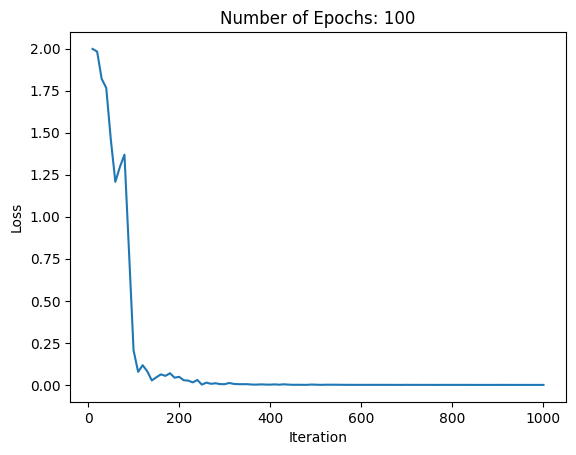

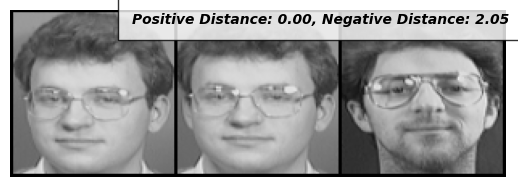

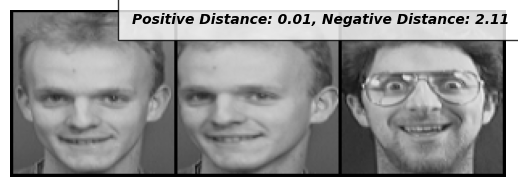

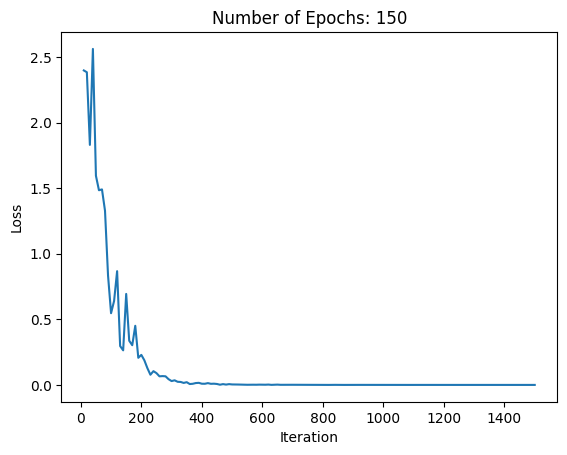

In [32]:
num_epochs = [50, 100, 150]

for epoch in num_epochs:
    counter, loss_history = train_network(0.0005, 64, epoch, test_dataloader) 
    show_plot(counter, loss_history, title=f"Number of Epochs: {epoch}")

Zadanie 3

In [33]:
class ModifiedSiameseNetwork(nn.Module):
    def __init__(self):
        super(ModifiedSiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1)     
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

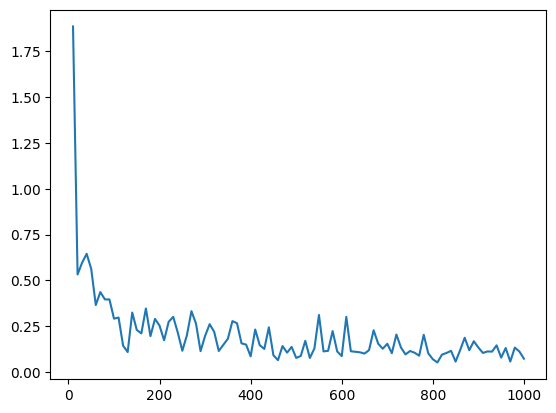

In [36]:
modified_net = ModifiedSiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(modified_net.parameters(), lr = 0.0005)

counter = []
loss_history = []
iteration_number= 0

# Iteracja po epokach
for epoch in range(100):

    # iteracja po pakietach
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Przeniesienie obrazów i etykiet do pamięci karty graficznej
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Ustawienie wartości gradientów na zero
        optimizer.zero_grad()

        # Przepuszczenie dwóch obrazów przez sieć i uzyskanie dwóch wektorów wyjściowych
        output1, output2 = modified_net(img0, img1)

        # Obliczenie wartości funkcji straty na podstawie wektorów wyjściowych
        loss_contrastive = criterion(output1, output2, label)

        # Obliczenie zmian wag w oparciu o wartość funkcji straty
        loss_contrastive.backward()

        # Aktualizacja wag sieci
        optimizer.step()

        # Wyświetlenie wartości funkcji straty co 10 pakietów
        if i % 10 == 0 :
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

filename = 'modified_siamese.sav'
pickle.dump(modified_net, open(filename, 'wb'))

show_plot(counter, loss_history)

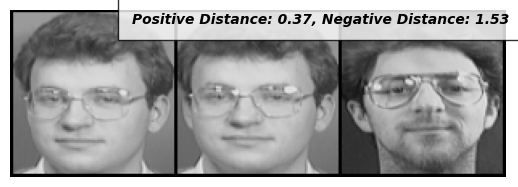

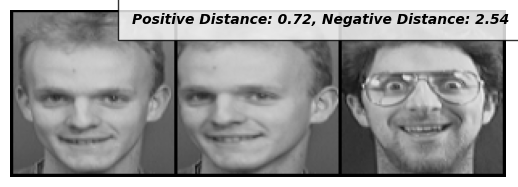

In [38]:
modified_net.eval() 

concatenated1 = torch.cat((anchor1, positive1, negative1), 0)
concatenated2 = torch.cat((anchor2, positive2, negative2), 0)

output_anchor, output_positive = modified_net(anchor1.to(device), positive1.to(device))
positive_distance = F.pairwise_distance(output_anchor, output_positive)
output_anchor, output_negative = modified_net(anchor1.to(device), negative1.to(device))
negative_distance = F.pairwise_distance(output_anchor, output_negative)
imshow(torchvision.utils.make_grid(concatenated1), f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')

output_anchor, output_positive = modified_net(anchor2.to(device), positive2.to(device))
positive_distance = F.pairwise_distance(output_anchor, output_positive)
output_anchor, output_negative = modified_net(anchor2.to(device), negative2.to(device))
negative_distance = F.pairwise_distance(output_anchor, output_negative)
imshow(torchvision.utils.make_grid(concatenated2), f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')


Zadanie 4

In [10]:
class TripletNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        anchor_tuple = random.choice(self.imageFolderDataset.imgs)
        positive_tuple = random.choice([img for img in self.imageFolderDataset.imgs if img[1] == anchor_tuple[1]])
        negative_tuple = random.choice([img for img in self.imageFolderDataset.imgs if img[1] != anchor_tuple[1]])

        anchor = Image.open(anchor_tuple[0]).convert("L")
        positive = Image.open(positive_tuple[0]).convert("L")
        negative = Image.open(negative_tuple[0]).convert("L")

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


In [11]:
class TripletNetwork(nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()
        # Use the same CNN architecture as in SiameseNetwork
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, anchor, positive, negative):
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)
        return output_anchor, output_positive, output_negative


In [12]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


In [13]:
folder_dataset = datasets.ImageFolder(root="data/data/faces/training")

transformation = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

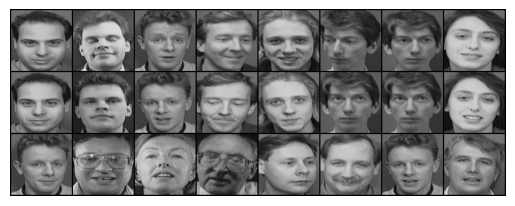

[0.41568628 0.40784314 0.40784314 ... 0.3019608  0.28235295 0.29411766]


In [52]:
vis_dataloader = DataLoader(triplet_dataset, shuffle=True, num_workers=0, batch_size=8, pin_memory=True)

example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [14]:
train_dataloader = vis_dataloader = DataLoader(triplet_dataset, shuffle=True, num_workers=0, batch_size=64, pin_memory=True)

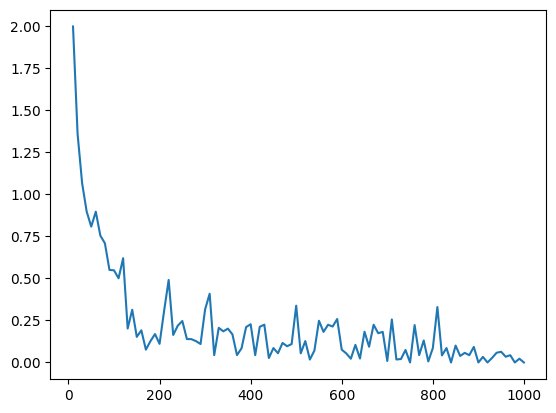

In [44]:
triplet_net = TripletNetwork().to(device)  
criterion = TripletLoss() 
optimizer = optim.Adam(triplet_net.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration_number = 0

for epoch in range(100):
    for i, (anchor, positive, negative) in enumerate(train_dataloader, 0):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        output_anchor, output_positive, output_negative = triplet_net(anchor, positive, negative)
        loss = criterion(output_anchor, output_positive, output_negative)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.item())

filename = 'triplet_net.sav'
pickle.dump(triplet_net, open(filename, 'wb'))

show_plot(counter, loss_history)


In [10]:
folder_dataset_test = datasets.ImageFolder(root="./data/data/faces/testing/")
triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation)
test_dataloader = DataLoader(triplet_dataset, shuffle=True, num_workers=0, batch_size=1, pin_memory=True)

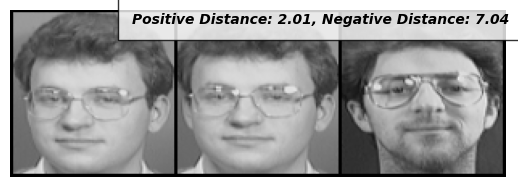

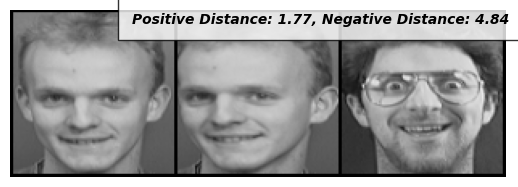

In [45]:
triplet_net.eval() 

anchor_batch = anchor1.to(device)
positive_batch = positive1.to(device)
negative_batch = negative1.to(device)

output_anchor, output_positive, output_negative = triplet_net(anchor_batch, positive_batch, negative_batch)

positive_distance = F.pairwise_distance(output_anchor, output_positive)
negative_distance = F.pairwise_distance(output_anchor, output_negative)

concatenated = torch.cat((anchor1, positive1, negative1), 0)
imshow(torchvision.utils.make_grid(concatenated),
        f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')


anchor_batch = anchor2.to(device)
positive_batch = positive2.to(device)
negative_batch = negative2.to(device)

output_anchor, output_positive, output_negative = triplet_net(anchor_batch, positive_batch, negative_batch)

positive_distance = F.pairwise_distance(output_anchor, output_positive)
negative_distance = F.pairwise_distance(output_anchor, output_negative)

concatenated = torch.cat((anchor2, positive2, negative2), 0)
imshow(torchvision.utils.make_grid(concatenated),
        f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')


Zadanie 5

In [46]:
def train_triplet_network(learning_rate, batch_size, num_epochs, test_dataloader):

    train_dataloader = DataLoader(triplet_dataset, shuffle=True, num_workers=0, batch_size=batch_size, pin_memory=True)

    net = TripletNetwork().to(device)
    criterion = TripletLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    counter = []
    loss_history = []
    iteration_number = 0

    for epoch in range(num_epochs):
        for i, (anchor, positive, negative) in enumerate(train_dataloader, 0):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()
            output_anchor, output_positive, output_negative = net(anchor, positive, negative)
            loss = criterion(output_anchor, output_positive, output_negative)
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss.item())

    net.eval() 

    anchor_batch = anchor1.to(device)
    positive_batch = positive1.to(device)
    negative_batch = negative1.to(device)

    output_anchor, output_positive, output_negative = net(anchor_batch, positive_batch, negative_batch)

    positive_distance = F.pairwise_distance(output_anchor, output_positive)
    negative_distance = F.pairwise_distance(output_anchor, output_negative)

    concatenated = torch.cat((anchor1, positive1, negative1), 0)
    imshow(torchvision.utils.make_grid(concatenated),
            f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')


    anchor_batch = anchor2.to(device)
    positive_batch = positive2.to(device)
    negative_batch = negative2.to(device)

    output_anchor, output_positive, output_negative = net(anchor_batch, positive_batch, negative_batch)

    positive_distance = F.pairwise_distance(output_anchor, output_positive)
    negative_distance = F.pairwise_distance(output_anchor, output_negative)

    concatenated = torch.cat((anchor2, positive2, negative2), 0)
    imshow(torchvision.utils.make_grid(concatenated),
            f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')

    return counter, loss_history



In [47]:
def imshow(img, text=None):
    img = img.cpu()  
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss, title):
    plt.plot(iteration, loss)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

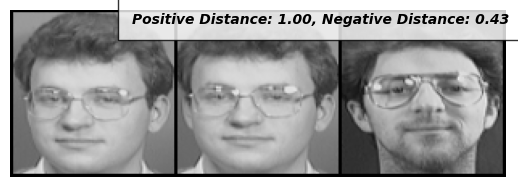

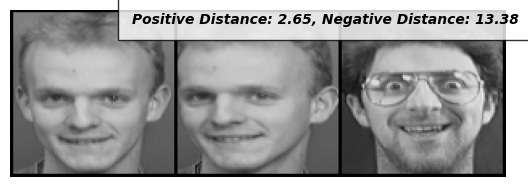

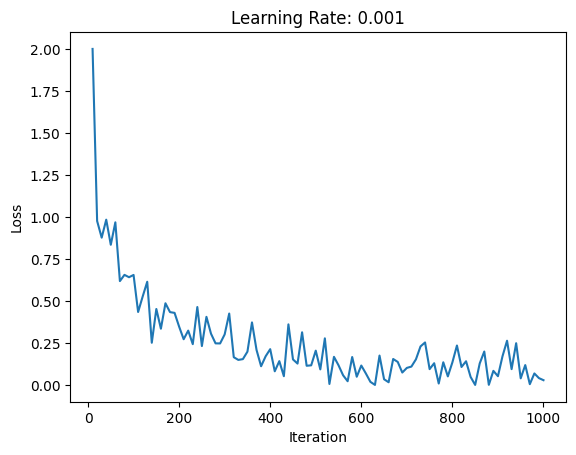

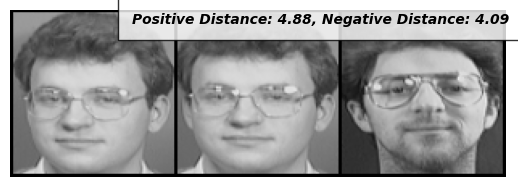

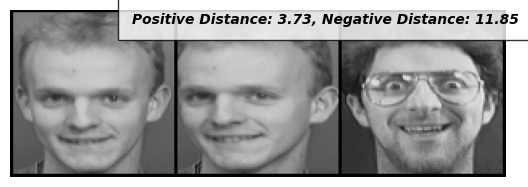

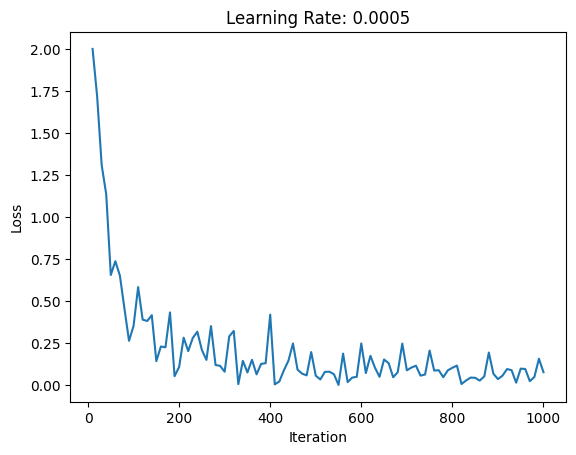

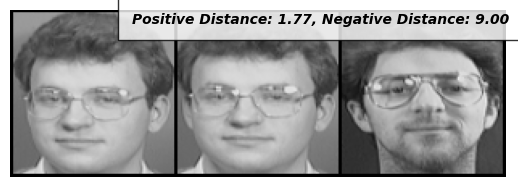

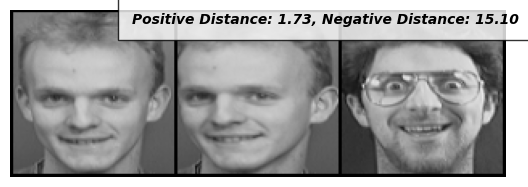

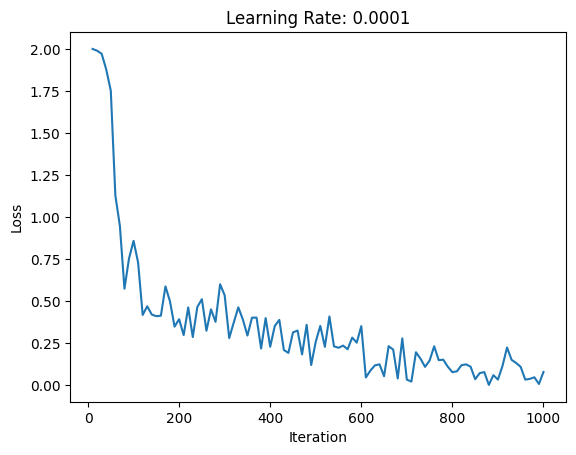

In [48]:
learning_rates = [0.001, 0.0005, 0.0001]

for lr in learning_rates:
    counter, loss_history = train_triplet_network(lr, 64, 100, test_dataloader)
    show_plot(counter, loss_history, title=f"Learning Rate: {lr}")

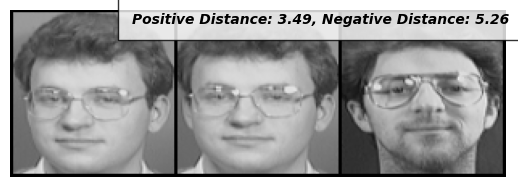

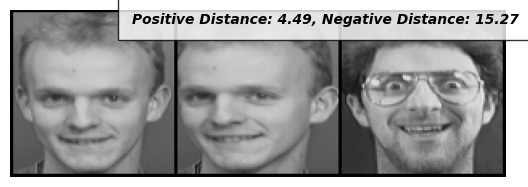

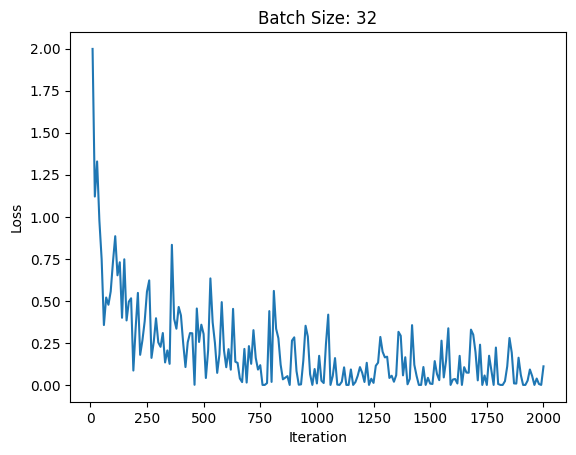

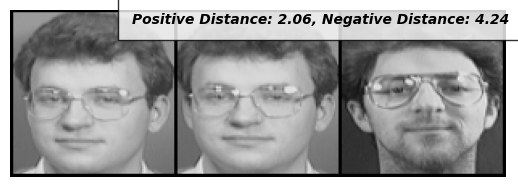

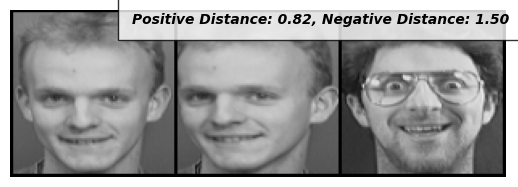

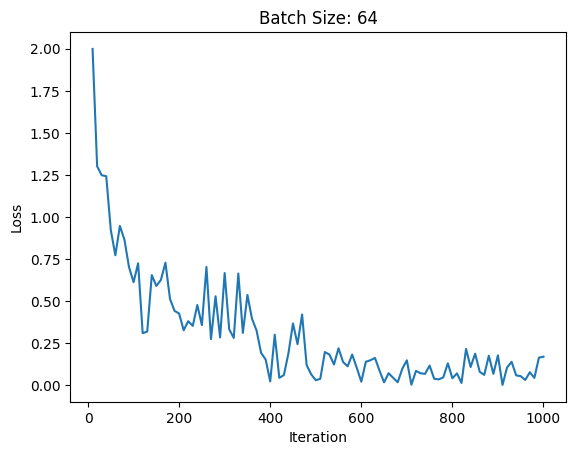

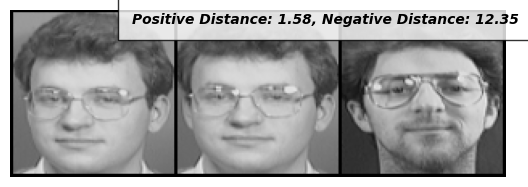

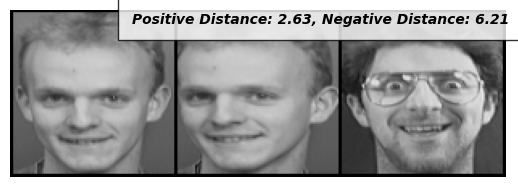

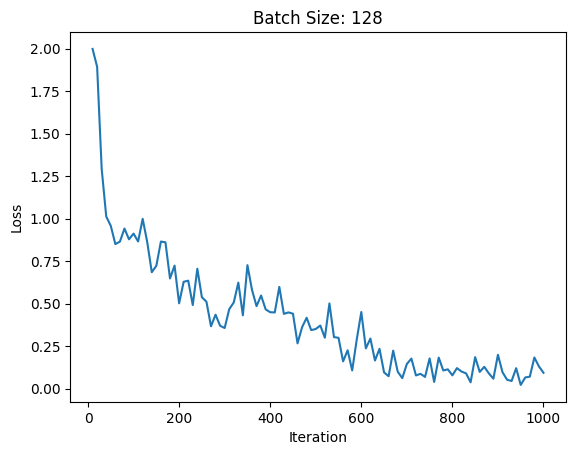

In [49]:
batch_sizes = [32, 64, 128]

for batch_size in batch_sizes:
    counter, loss_history = train_triplet_network(0.0005, batch_size, 100, test_dataloader)
    show_plot(counter, loss_history, title=f"Batch Size: {batch_size}")

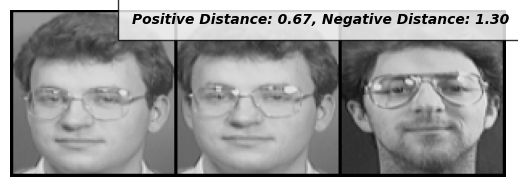

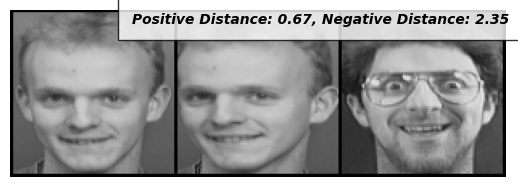

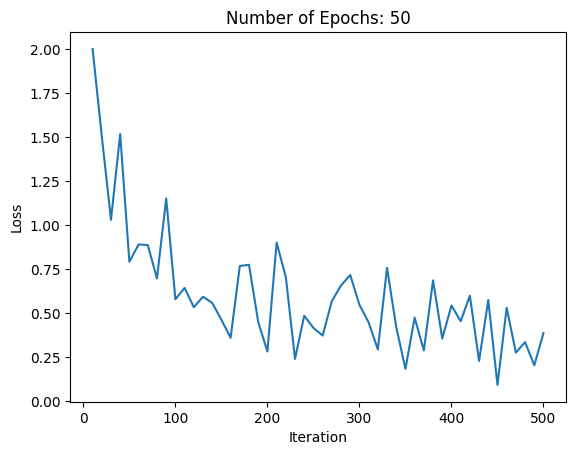

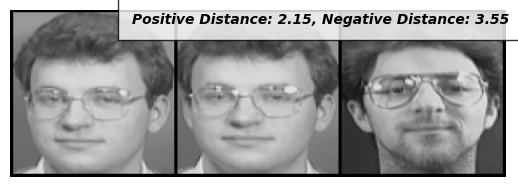

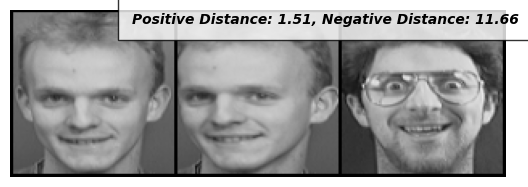

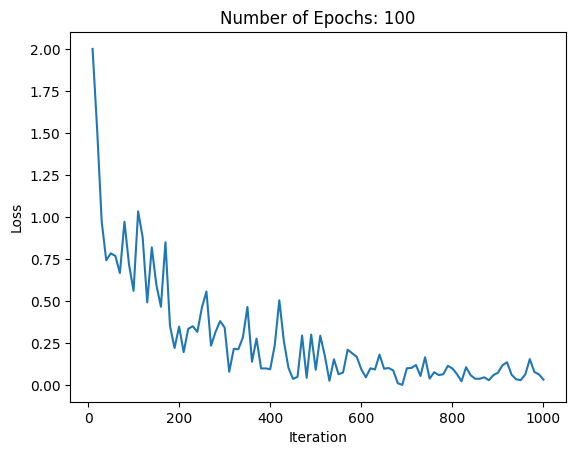

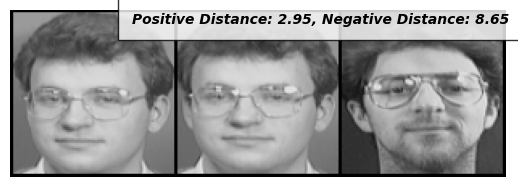

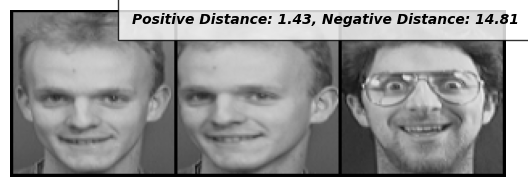

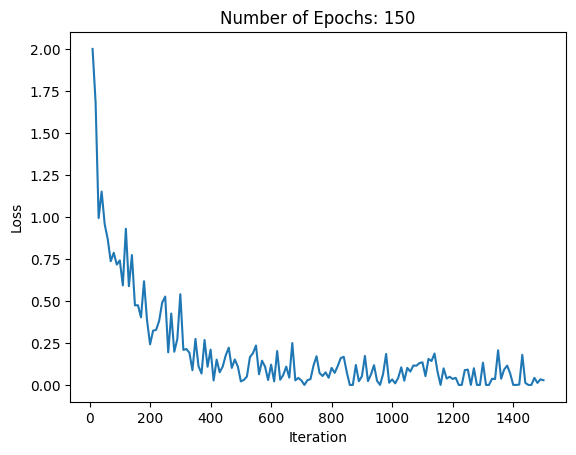

In [50]:
num_epochs = [50, 100, 150]

for epoch in num_epochs:
    counter, loss_history = train_triplet_network(0.0005, 64, epoch, test_dataloader) 
    show_plot(counter, loss_history, title=f"Number of Epochs: {epoch}")

In [51]:
class ModifiedTripletNetwork(nn.Module):
    def __init__(self):
        super(ModifiedTripletNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4),  # Reduced number of filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1),  # Changed filter count
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # Additional Conv Layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Added dropout
            nn.Conv2d(256, 256, kernel_size=1, stride=1),  # Additional Conv Layer
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256)  # Added batch normalization
        )

        # Calculate the output size after the convolutional layers
        conv_output_size = self._get_conv_output_size((1, 100, 100))

        self.fc1 = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)
        )

    def _get_conv_output_size(self, input_size):
        # Temporarily switch to evaluation mode
        self.eval()

        # Create a dummy input tensor with the input size
        batch_size = 1
        input_tensor = torch.zeros(batch_size, *input_size)

        # Forward pass through the convolutional layers only
        output_tensor = self.cnn1(input_tensor)

        # Switch back to training mode
        self.train()

        return int(np.prod(output_tensor.size()))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, anchor, positive, negative):
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)
        return output_anchor, output_positive, output_negative



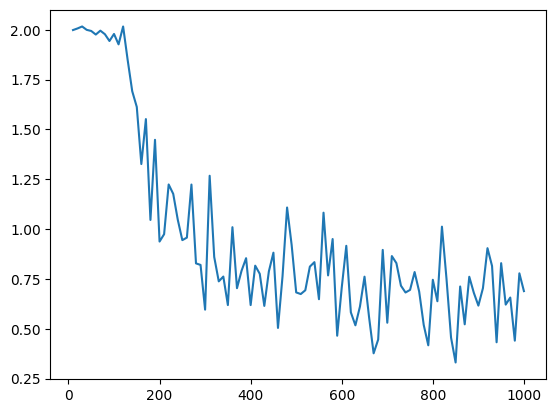

In [55]:
triplet_net = ModifiedTripletNetwork().to(device)  
criterion = TripletLoss() 
optimizer = optim.Adam(triplet_net.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration_number = 0

for epoch in range(100):
    for i, (anchor, positive, negative) in enumerate(train_dataloader, 0):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        output_anchor, output_positive, output_negative = triplet_net(anchor, positive, negative)
        loss = criterion(output_anchor, output_positive, output_negative)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.item())

filename = 'modified_triplet_net.sav'
pickle.dump(triplet_net, open(filename, 'wb'))

show_plot(counter, loss_history)

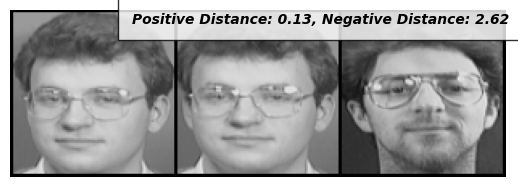

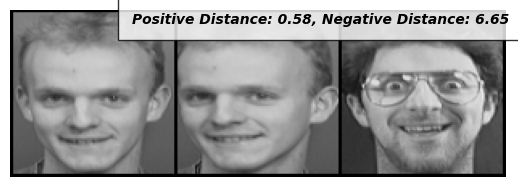

In [56]:
triplet_net.eval() 

anchor_batch = anchor1.to(device)
positive_batch = positive1.to(device)
negative_batch = negative1.to(device)

output_anchor, output_positive, output_negative = triplet_net(anchor_batch, positive_batch, negative_batch)

positive_distance = F.pairwise_distance(output_anchor, output_positive)
negative_distance = F.pairwise_distance(output_anchor, output_negative)

concatenated = torch.cat((anchor1, positive1, negative1), 0)
imshow(torchvision.utils.make_grid(concatenated),
        f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')


anchor_batch = anchor2.to(device)
positive_batch = positive2.to(device)
negative_batch = negative2.to(device)

output_anchor, output_positive, output_negative = triplet_net(anchor_batch, positive_batch, negative_batch)

positive_distance = F.pairwise_distance(output_anchor, output_positive)
negative_distance = F.pairwise_distance(output_anchor, output_negative)

concatenated = torch.cat((anchor2, positive2, negative2), 0)
imshow(torchvision.utils.make_grid(concatenated),
        f'Positive Distance: {positive_distance.item():.2f}, Negative Distance: {negative_distance.item():.2f}')

Zadanie 6

In [69]:
siamese_net = SiameseNetwork().to(device)
triplet_net = TripletNetwork().to(device)

siamese_criterion = ContrastiveLoss()
triplet_criterion = TripletLoss()
siamese_optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)
triplet_optimizer = optim.Adam(triplet_net.parameters(), lr=0.0001)

folder_dataset_train = datasets.ImageFolder(root="./data/data/faces/training/")
transformation = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

siamese_train_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train, transform=transformation)
triplet_train_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_train, transform=transformation)

siamese_train_dataloader = DataLoader(siamese_train_dataset, shuffle=True, num_workers=0, batch_size=32, pin_memory=True)
triplet_train_dataloader = DataLoader(triplet_train_dataset, shuffle=True, num_workers=0, batch_size=128, pin_memory=True)

counter_siamese = []
loss_history_siamese = []
iteration_number = 0

for epoch in range(100):
    for i, (img0, img1, label) in enumerate(siamese_train_dataloader, 0):
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        siamese_optimizer.zero_grad()

        output1, output2 = siamese_net(img0, img1)

        loss_contrastive = siamese_criterion(output1, output2, label)

        loss_contrastive.backward()

        siamese_optimizer.step()

        if i % 10 == 0 :
            iteration_number += 10
            counter_siamese.append(iteration_number)
            loss_history_siamese.append(loss_contrastive.item())

counter_triplet = []
loss_history_triplet = []
iteration_number = 0

for epoch in range(100):
    for i, (anchor, positive, negative) in enumerate(triplet_train_dataloader, 0):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        triplet_optimizer.zero_grad()
        output_anchor, output_positive, output_negative = triplet_net(anchor, positive, negative)
        loss = triplet_criterion(output_anchor, output_positive, output_negative)
        loss.backward()
        triplet_optimizer.step()
        
        if i % 10 == 0:
            iteration_number += 10
            counter_triplet.append(iteration_number)
            loss_history_triplet.append(loss.item())


In [133]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32)), img0_tuple[1], img1_tuple[1]

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


In [117]:
class TripletNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        anchor_tuple = random.choice(self.imageFolderDataset.imgs)
        positive_tuple = random.choice([img for img in self.imageFolderDataset.imgs if img[1] == anchor_tuple[1]])
        negative_tuple = random.choice([img for img in self.imageFolderDataset.imgs if img[1] != anchor_tuple[1]])

        anchor = Image.open(anchor_tuple[0]).convert("L")
        positive = Image.open(positive_tuple[0]).convert("L")
        negative = Image.open(negative_tuple[0]).convert("L")

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative, anchor_tuple[1]

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


In [134]:
folder_dataset_test = datasets.ImageFolder(root="./data/data/faces/testing/")
transformation = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

siamese_test_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation)

triplet_test_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation)

siamese_test_dataloader = DataLoader(siamese_test_dataset, shuffle=True, num_workers=0, batch_size=32, pin_memory=True)
triplet_test_dataloader = DataLoader(triplet_test_dataset, shuffle=True, num_workers=0, batch_size=128, pin_memory=True)

In [123]:
from sklearn.manifold import TSNE

def extract_embeddings_and_labels_siamese(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for img0, _, _, class_label_img0, _ in dataloader:
            img0 = img0.to(device)
            emb = model.forward_once(img0)
            embeddings.append(emb.cpu())
            labels.extend(class_label_img0.cpu().numpy())
    return torch.cat(embeddings), labels

def extract_embeddings_triplet(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for anchor, _, _, label_anchor in dataloader:
            anchor = anchor.to(device)
            emb = model.forward_once(anchor)
            embeddings.append(emb.cpu())
            labels.extend(label_anchor.cpu().numpy())
    return torch.cat(embeddings), labels

siamese_embeddings, siamese_labels = extract_embeddings_and_labels_siamese(siamese_net, siamese_test_dataloader)
triplet_embeddings, triplet_labels = extract_embeddings_triplet(triplet_net, triplet_test_dataloader)

tsne = TSNE(n_components=2, random_state=123)
siamese_embeddings_2d = tsne.fit_transform(siamese_embeddings)

n_samples_triplet = len(triplet_embeddings)
tsne_triplet = TSNE(n_components=2, random_state=123)
triplet_embeddings_2d = tsne_triplet.fit_transform(triplet_embeddings)


In [137]:
from sklearn.metrics import roc_auc_score
import torch

def calculate_auc_siamese(model, dataloader):
    model.eval()
    distances = []
    labels = []
    with torch.no_grad():
        for img0, img1, label, _, _ in dataloader:
            img0, img1 = img0.to(device), img1.to(device)
            output1, output2 = model(img0, img1)
            distance = torch.nn.functional.pairwise_distance(output1, output2)
            distances.extend(distance.cpu().numpy())
            labels.extend(label.cpu().numpy())
    auc_score = roc_auc_score(labels, distances)
    return auc_score

def calculate_auc_triplet(model, dataloader):
    model.eval()
    distances_diff = []
    labels = []
    with torch.no_grad():
        for anchor, positive, negative, _ in dataloader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            output_anchor, output_positive, output_negative = model(anchor, positive, negative)
            positive_distance = torch.nn.functional.pairwise_distance(output_anchor, output_positive)
            negative_distance = torch.nn.functional.pairwise_distance(output_anchor, output_negative)
            distances_diff.extend((positive_distance - negative_distance).cpu().numpy())
            labels.extend([1 if pd < nd else 0 for pd, nd in zip(positive_distance, negative_distance)])
    auc_score = roc_auc_score(labels, distances_diff)
    return auc_score


auc_siamese = calculate_auc_siamese(siamese_net, siamese_test_dataloader)
auc_triplet = calculate_auc_triplet(triplet_net, triplet_test_dataloader)


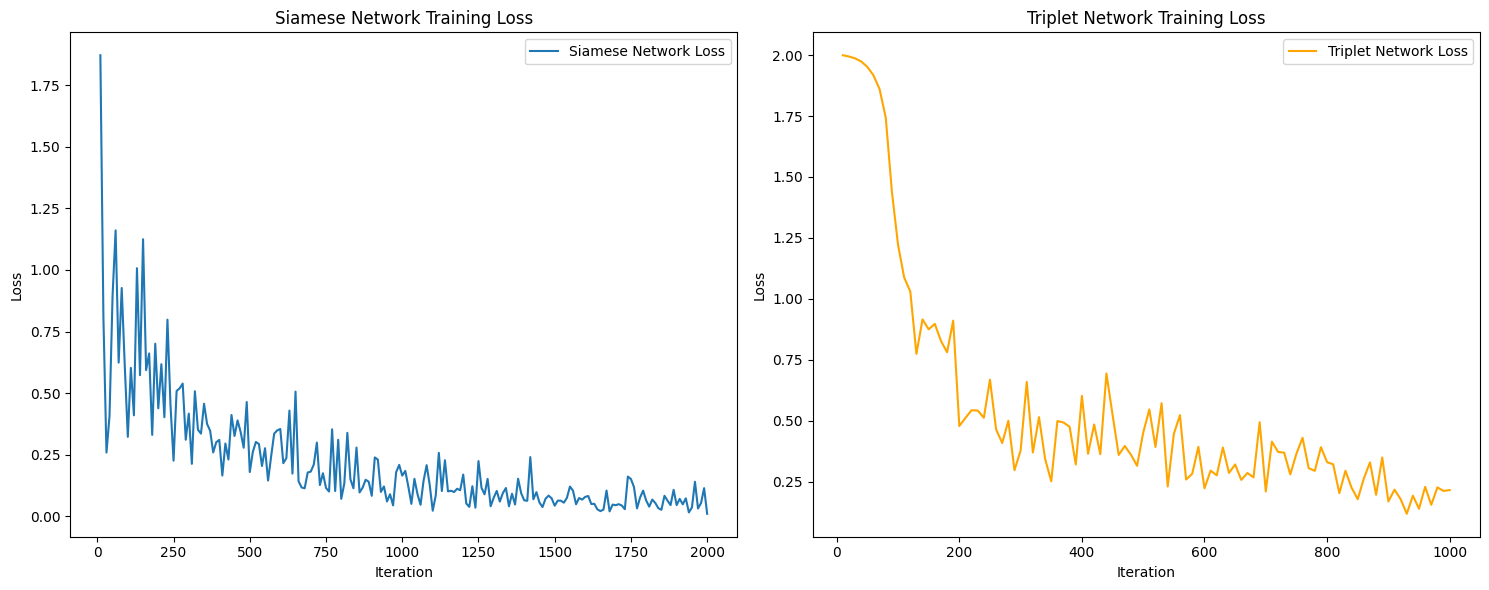

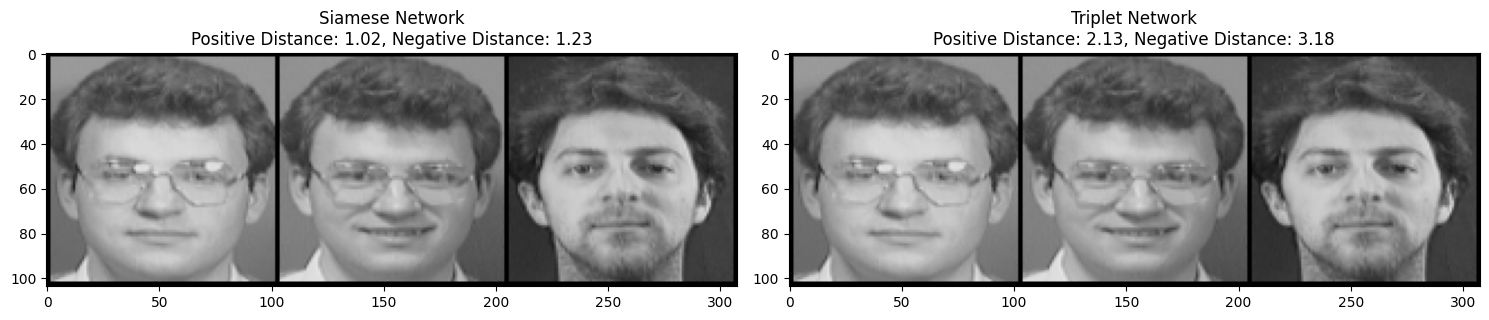

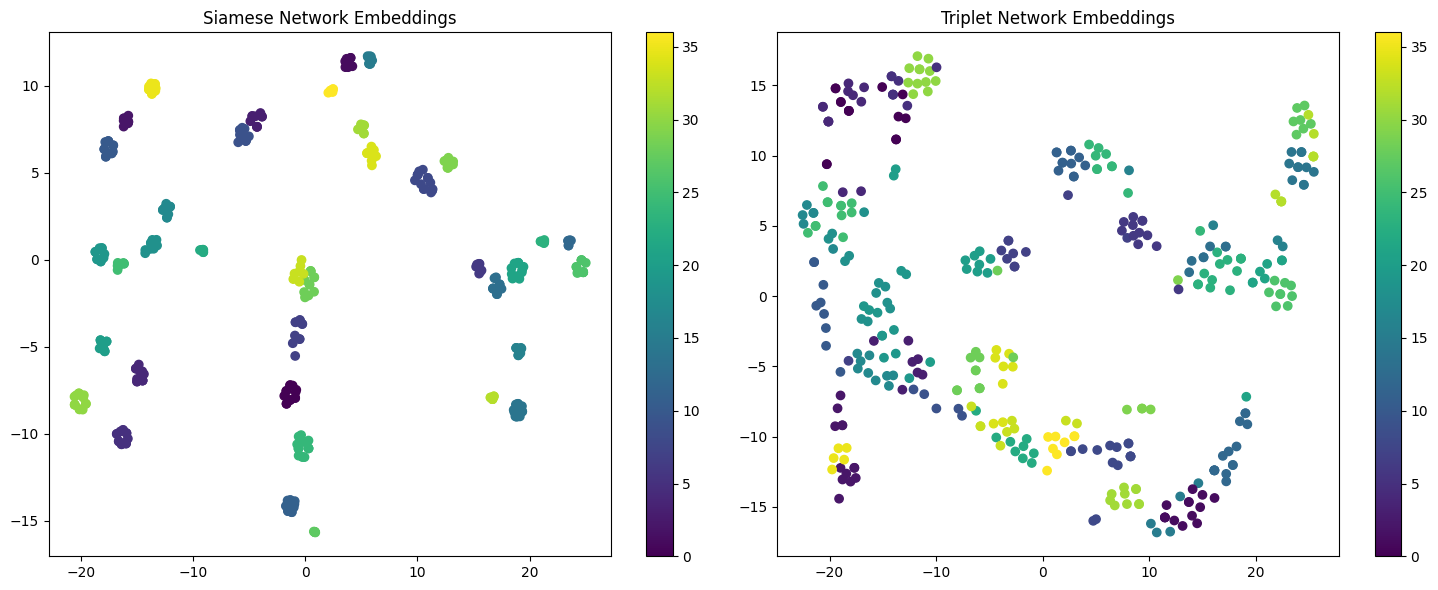

Siamese AUC: 0.7239819004524887
Triplet AUC: 0.6296296296296295


In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(counter_siamese, loss_history_siamese, label='Siamese Network Loss')
ax1.set_title('Siamese Network Training Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(counter_triplet, loss_history_triplet, label='Triplet Network Loss', color='orange')
ax2.set_title('Triplet Network Training Loss')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

siamese_net.eval()
triplet_net.eval()

# Process with Siamese Network
output_anchor_siamese, output_positive_siamese = siamese_net(anchor1.to(device), positive1.to(device))
positive_distance_siamese = F.pairwise_distance(output_anchor_siamese, output_positive_siamese)
output_anchor_siamese, output_negative_siamese = siamese_net(anchor1.to(device), negative1.to(device))
negative_distance_siamese = F.pairwise_distance(output_anchor_siamese, output_negative_siamese)

# Process with Triplet Network
output_anchor_triplet, output_positive_triplet, output_negative_triplet = triplet_net(anchor1.to(device), positive1.to(device), negative1.to(device))
positive_distance_triplet = F.pairwise_distance(output_anchor_triplet, output_positive_triplet)
negative_distance_triplet = F.pairwise_distance(output_anchor_triplet, output_negative_triplet)

# Concatenate images for display
concatenated_siamese = torch.cat((anchor1, positive1, negative1), 0)
concatenated_triplet = torch.cat((anchor1, positive1, negative1), 0)

# Create a figure for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Display Siamese Network images
ax1.imshow(torchvision.utils.make_grid(concatenated_siamese).permute(1, 2, 0))  # Adjust this line if imshow is different
ax1.set_title(f'Siamese Network\nPositive Distance: {positive_distance_siamese.item():.2f}, Negative Distance: {negative_distance_siamese.item():.2f}')

# Display Triplet Network images
ax2.imshow(torchvision.utils.make_grid(concatenated_triplet).permute(1, 2, 0))  # Adjust this line if imshow is different
ax2.set_title(f'Triplet Network\nPositive Distance: {positive_distance_triplet.item():.2f}, Negative Distance: {negative_distance_triplet.item():.2f}')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = ax1.scatter(siamese_embeddings_2d[:, 0], siamese_embeddings_2d[:, 1], c=siamese_labels, cmap='viridis')
fig.colorbar(scatter1, ax=ax1)
ax1.set_title('Siamese Network Embeddings')


scatter2 = ax2.scatter(triplet_embeddings_2d[:, 0], triplet_embeddings_2d[:, 1], c=triplet_labels, cmap='viridis')
fig.colorbar(scatter2, ax=ax2)
ax2.set_title('Triplet Network Embeddings')

plt.tight_layout()
plt.show()

print(f"Siamese AUC: {auc_siamese}")
print(f"Triplet AUC: {auc_triplet}")
